## Test/Validate SF Error Metric with Simulated DRW LCs

**Author(s):** Weixiang Yu & Gordon Richards
<br>**Last updated:** 03/03/2021
<br>**Short description:**
This notebook implements a metric to validate the 'SFErrorMetric' using simulated DRW light curves. At each healpixel, this metric simulate a DRW light curve with the input parameter drawn from a pre-defined distribution and fit the simulated light curve using __EzTao__. The best-fit DRW paramters will be returned. The final metric is based on the KL divergence between the input distirbution of DRW parameters and the distribution of the best-fit DRW parameters.

### 0. Software Setup

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import glob
import os
import seaborn as sns
from scipy import stats

In [3]:
# automatically extract username
your_username = os.getcwd().split('/')[5]
print(f'Your automatically extracted username is: {your_username}.'
        '\nIf it is incorrect, please mannually reset it.')

Your automatically extracted username is: ywx649999311.
If it is incorrect, please mannually reset it.


##### Import the sims_maf modules needed.

In [4]:
# import custom stacker from script
from AGNStackers import MagErrStacker

# import lsst.sim.maf moduels modules
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
from lsst.sims.maf.stackers import BaseStacker
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

# import convenience functions
from opsimUtils import *

### 1. Generate a test distribution of DRW parameters
This distribution is derived from DRW fits of real SDSS Stripe 82 QSO light curves. 

In [5]:
drw_sources = pd.read_csv('Data/drw_mock_source.csv')
drw_sources.head(2)

,id,train_id,tau_g,amp_g
0,4652811,0,14.566014,0.143470
1,4837785,1,319.851335,0.309899


(-2, 10)

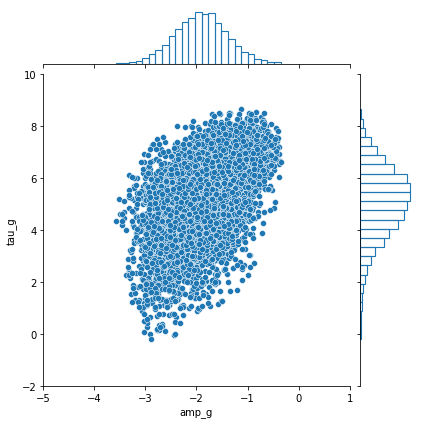

In [6]:
plot = sns.jointplot(data=drw_sources, x=np.log(drw_sources['amp_g']), 
                      y=np.log(drw_sources['tau_g']), 
                      marginal_kws=dict(bins=25, fill=False))

plot.ax_marg_x.set_xlim(-5, 1)
plot.ax_marg_y.set_ylim(-2, 10)

#### 1.1 Fit 2D gaussian to the source distribution of DRW parameters

In [7]:
from astropy.modeling import models, fitting

In [8]:
# use hist2d to turn data into pixels
n, x_edges, y_edges = np.histogram2d(np.log(drw_sources.amp_g).values, 
                         np.log(drw_sources.tau_g).values, bins=50, density=True)

# get centers of pixels
x_centers = (x_edges[:-1] + x_edges[1:])/2
y_centers = (y_edges[:-1] + y_edges[1:])/2

# turn centers into meshgrid
xs, ys = np.meshgrid(x_centers, y_centers)

# init a 2d gaussian model using astropy
g2d_init = models.Gaussian2D(amplitude=2, x_mean=-2, y_mean=5, x_stddev=0.6, y_stddev=1.5)
fit_t = fitting.LevMarLSQFitter()

# fit the binned data to 2d gaussian
g2d = fit_t(g2d_init, xs, ys, n)

In [9]:
# print model & check best-fit guassian parameters
g2d

<Gaussian2D(amplitude=0.27149938, x_mean=-1.62852339, y_mean=4.43635868, x_stddev=0.42385269, y_stddev=1.38254896, theta=-0.16980445)>

##### Compute correlation coefficient from rotation angle

In [10]:
# Ref -> https://www.unige.ch/sciences/astro/files/5413/8971/4090/2_Segransan_StatClassUnige.pdf
# convert to theta in the ref
ref_theta = np.pi/2 + g2d.theta
rho = np.tan(2*ref_theta)*(g2d.x_stddev**2 - g2d.y_stddev**2)/(2*g2d.x_stddev*g2d.y_stddev)

# print mean
mean = np.array([g2d.x_mean.value, g2d.y_mean.value])
print(mean)

# write out the cov_matrix
cov_m = [[g2d.x_stddev**2, rho*g2d.x_stddev*g2d.y_stddev], [rho*g2d.x_stddev*g2d.y_stddev, g2d.y_stddev**2]]
cov_m

[-1.62852339  4.43635868]


[[0.17965110256085912, 0.3059181100985638],
 [0.3059181100985638, 1.9114416154496565]]

#### 1.2 Randomly draw sample from the above 2D gaussian distribution & Check if it matches to input data

(-2, 10)

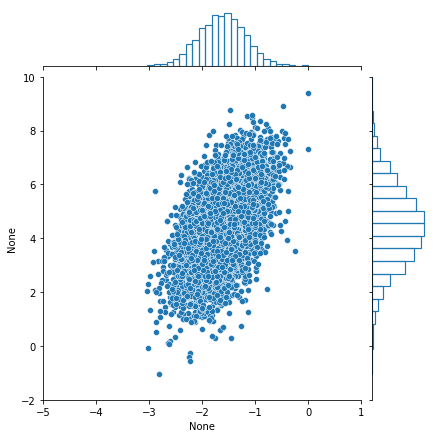

In [11]:
# define 2d guassian parameters
rand_x, rand_y = np.random.multivariate_normal(mean, cov_m, 5000).T

# plot
plot = sns.jointplot(x=rand_x, 
              y=rand_y, 
              marginal_kws=dict(bins=25, fill=False))

plot.ax_marg_x.set_xlim(-5, 1)
plot.ax_marg_y.set_ylim(-2, 10)

#### Note:
The exact match between the fitted 2D Gaussian and the source distribution is not as important. What we really want is just a distribution that can be easily sampled from in the metric.

### 2. The MAF Metric
#### 2.1 Metric Class

In [18]:
from eztao.carma import DRW_term
from eztao.ts import gpSimByTime, drw_fit
from celerite import GP

In [25]:
from lsst.sims.maf.metrics import BaseMetric
from astropy.stats import mad_std

class DRWFitMetric(BaseMetric):
    """DRW Fitting Accuracy Metric."""
    
    # see eqn #4 & #5 in overview paper
    gamma = {'u': 0.038, 'g':0.039, 'r':0.039, 'i':0.039, 'z':0.039, 'y':0.039}
    sigmaSys = {'u':0.0075, 'g':0.005, 'r':0.005, 'i':0.005, 'z':0.0075, 'y':0.0075}
    
    # DRW parameters distribtuion
    drw_mean = [-1.62852339,  4.43635868]
    drw_cov = [[0.17965110256085912, 0.3059181100985638],
               [0.3059181100985638, 1.9114416154496565]]
    
    rng = np.random.default_rng()
    
    def __init__(self, mag, band, timesCol='observationStartMJD', m5Col='fiveSigmaDepth', 
                 units='mag', **kwargs):
        
        """Init function for metric class.
        
        Args:
            mag(float): The magnitude of the sources.
            band(str): In which band/filter to run this metric.
        """
        
        # Assign metric parameters to instance object
        self.mag = mag
        self.timesCol = timesCol
        self.m5Col = m5Col
        self.filterCol = 'filter'
        self.metricName = f'DRWFit_{mag}_{band}'
        super(DRWFitMetric, self).__init__(col=[self.timesCol, self.m5Col, self.filterCol], metricName=self.metricName, 
                                           units=units, metricDtype='object', **kwargs)

    def compute_err(self, mags, simData):
        """Compute photometric error given m5 depth and source mags."""
        
        band = np.unique(simData[self.filterCol])[0]
        diffM = mags - simData[self.m5Col]
        varRand = (0.04-self.gamma[band])*np.power(10, 0.4*diffM) + \
                  self.gamma[band]*np.power(10, 0.8*diffM)
        
        return np.sqrt(varRand + self.sigmaSys[band]**2)
        
    def run(self, dataSlice, slicePoint=None):
        """Code executed at each healpix pixel to compute the metric"""
        
        # If the total number of visits < 2, mask as bad pixel
        if dataSlice.size < 2:
            return self.badval

        # generate DRW parameter from pre-defined distribution
        log_amp, log_tau = self.rng.multivariate_normal(self.drw_mean, self.drw_cov, 1)[0]

        # create eztao kernel and simulated LC
        kernel = DRW_term(log_amp, log_tau)
        sorted_time = np.sort(dataSlice[self.timesCol]) 
        tIn = sorted_time - sorted_time[0]
        tOut, yOut, yerrOut = gpSimByTime(kernel, 100, tIn)
        
        # make final time series
        t = tIn
        y = yOut - yerrOut  + self.mag
        yerr = self.compute_err(y, dataSlice)

        # fit simulated data
        best_drw = drw_fit(t, y, yerr)

        return best_drw

/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/metrics/baseMetric.py:39: UserWarning: Redefining metric __main__.DRWFitMetric! (there are >1 metrics with the same name)
  warnings.warn('Redefining metric %s! (there are >1 metrics with the same name)' % (metricname))


#### 2.2 Run \& Test (on a single point)

In [20]:
#Read in an opSim (in this case "baseline_v1.5_10yrs.db")
opsdb1 = db.OpsimDatabase('/home/idies/workspace/lsst_cadence/FBS_1.5/baseline_v1.5_10yrs.db')
outDir = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/tmp/DRW/030421/'.format(your_username)
resultsDb = db.ResultsDb(outDir=outDir)

In [26]:
drw_metric = DRWFitMetric(22, 'g') # default configs
slicer = slicers.UserPointsSlicer(ra=[10.11], dec=[2.14])
constraint = 'filter = "g"'
testmb = metricBundles.MetricBundle(drw_metric, slicer, constraint)

In [29]:
testbd = {'pointDRW': testmb}
group = metricBundles.MetricBundleGroup(testbd, opsdb1, outDir=outDir, resultsDb=resultsDb)
group.runAll()

Querying database SummaryAllProps with constraint filter = "g" for columns ['observationStartMJD', 'filter', 'fiveSigmaDepth', 'fieldDec', 'fieldRA']
Found 223871 visits
Running:  ['pointDRW']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [30]:
print(f'Best-fit DRW at gmag=22 at a specificed location is: {testmb.metricValues.data[0]}')

Best-fit DRW at gmag=22 at a specificed location is: [1.86099269e-01 4.30101794e+02]


#### 2.3 Run test over the whole sky

In [31]:
slicer2 = slicers.HealpixSlicer(nside=16)
constraint2 = 'filter = "g"'
constraint2 += ' and note not like "DD%"'

skymb = metricBundles.MetricBundle(drw_metric, slicer2, constraint2)

skydb = {'skyDRW': skymb}

Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes


In [32]:
group2 = metricBundles.MetricBundleGroup(skydb, opsdb1, outDir=outDir, resultsDb=resultsDb)
group2.runAll()

Querying database SummaryAllProps with constraint filter = "g" and note not like "DD%" for columns ['observationStartMJD', 'filter', 'fiveSigmaDepth', 'fieldDec', 'fieldRA']
Found 211754 visits
Running:  ['skyDRW']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


#### 2.4 Plot the distribution of best-fit DRW parameters on simulated LSST light curves.

In [33]:
mbValues = skymb.metricValues.copy()
mask = mbValues.mask
data = mbValues.data[~mask]

In [34]:
data_reshaped = np.concatenate(data).reshape(2024, 2)

(-2, 10)

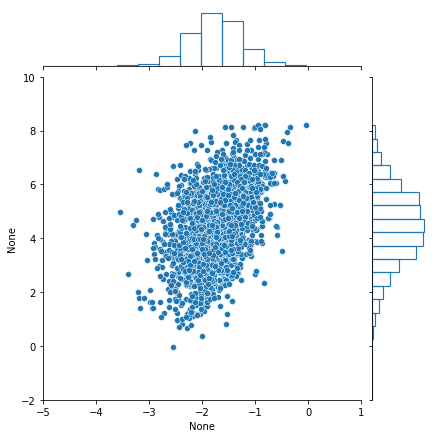

In [51]:
plot = sns.jointplot(x=np.log(data_reshaped[:, 0]), 
              y=np.log(data_reshaped[:, 1]), 
              marginal_kws=dict(bins=25, fill=False))

plot.ax_marg_x.set_xlim(-5, 1)
plot.ax_marg_y.set_ylim(-2, 10)

#### 2.5 Compute Reletive Entropy
- use 2d histogram to turn metric samples into a discrete probability
- generate another sequence to represent the input probability
- compute KL divergence using scipy.stats.entropy

In [78]:
fit_n, fit_x_edges, fit_y_edges = np.histogram2d(np.log(data_reshaped[:, 0]), 
                                                 np.log(data_reshaped[:, 1]),
                                                 range=[[-5, 1], [-2, 10]],
                                                 bins = 50)
# determine center of bins
fit_x_centers = (fit_x_edges[:-1] + fit_x_edges[1:])/2
fit_y_centers = (fit_y_edges[:-1] + fit_y_edges[1:])/2

# make meshgrid
fit_xs, fit_ys = np.meshgrid(fit_x_centers, fit_y_centers)
pos = np.dstack((fit_xs, fit_ys))

# evaluate input 2d gaussian prob
input_g2d_rv = stats.multivariate_normal(mean, cov_m)
qk = input_g2d_rv.pdf(pos)

In [101]:
# compute KL div
kld = stats.entropy(fit_n.flatten(), qk.flatten(), base=2)
print(f'The KL divergence between the input distribution and the best-fit distribution is:{kld}')

The KL divergence between the input distribution and the best-fit distribution is:1.264240509906619


#### 2.6 Make skymap and histograms for each DRW parameters
__Note:__ The actual "metric value" at each pixel doesn't reflect the quality of the cadence, the deviation of the out distribution from the input distribution does. That is, the smaller the KL divergence the better the simulated observing cadence.  

In [92]:
def plotSky_MO(mb, metric_idx, dim=1, scale_func=np.copy, extra_title=''):
    '''
    Plot High-Res DDF skymap. 

    Args:
        mb: MetricBundle object.
        metric_idx(int): The index of the metric to plot in the multi-output metric
        dim (int): The number of metric values return for each pixel. Defaults to 1.
        scale_func (func): A scaling function for the metric data, e.g., np.log10. 
            Defaults to np.copy.
        extra_title(str): Title text (in addition to metric name and run name). 
    '''
    
    fig = plt.figure(dpi=120)
    try:
        mbValues = mb.metricValues.copy()
#         mbValues = mb.copy()
        mask = mbValues.mask
        data = mbValues.data[~mask]
        shape = (data.shape[0], dim)
        plot_data = np.concatenate(data, axis=0).reshape(shape)[:, metric_idx]
        mbValues.data[~mask] = scale_func(plot_data)
    except Exception as e:
        print(e)
        return None
    
    _ = hp.mollview(mbValues, flip='astro')
    _ = hp.graticule(verbose=False)
    
    title = str(extra_title)
    title += f' Metric:{mb.metric.name}, RunName:{mb.runName}'
    plt.title(title)
    
def plotHist_MO(mb, metric_idx, xlabel, dim=1, scale_func=np.copy, extra_title=''):
    '''
    Plot High-Res DDF skymap. 

    Args:
        mb: MetricBundle object.
        metric_idx(int): The index of the metric to plot in the multi-output metric.
        dim (int): The number of metric values return for each pixel. Defaults to 1.
        scale_func (func): A scaling function for the metric data, e.g., np.log10. 
            Defaults to np.copy.
        title(str): Title text (in addition to metric name and run name). 
    '''
    fig = plt.figure(dpi=120)
    try:
        mbValues = mb.metricValues.copy()
#         mbValues = mb.copy()
        mask = mbValues.mask
        data = mbValues.data[~mask]
        shape = (data.shape[0], dim)
        plot_data = np.concatenate(data, axis=0).reshape(shape)[:, metric_idx]
        mbValues.data[~mask] = scale_func(plot_data)
    except Exception as e:
        print(e)
        return None
    
#     return (mbValues.data[~mask], plot_data)
    _ = plt.hist(mbValues.data[~mask].astype(float), bins='fd', histtype='step', 
                 label=mb.runName)
#     _ = plt.hist(mbValues.data[~mask].astype(float), bins='fd', histtype='step')
    plt.xlabel(xlabel)
    plt.ylabel('Number of Bins')
    
    # plot title
    title = str(extra_title)
    title += f' Metric:{mb.metric.name}, RunName:{mb.runName}'
    plt.title(title)

<Figure size 720x480 with 0 Axes>

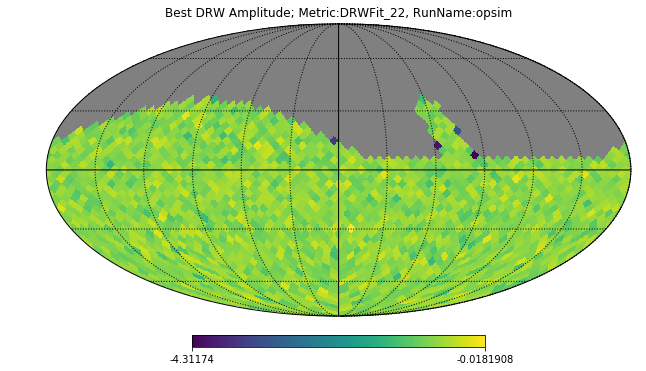

In [99]:
plotSky_MO(skymb, 0, dim=2, scale_func=np.log10, extra_title='Best DRW Amplitude;')

<Figure size 720x480 with 0 Axes>

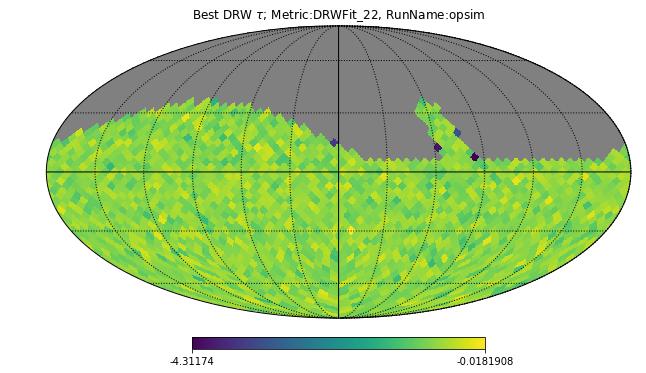

In [103]:
plotSky_MO(skymb, 0, dim=2, scale_func=np.log10, extra_title='Best DRW Tau;')

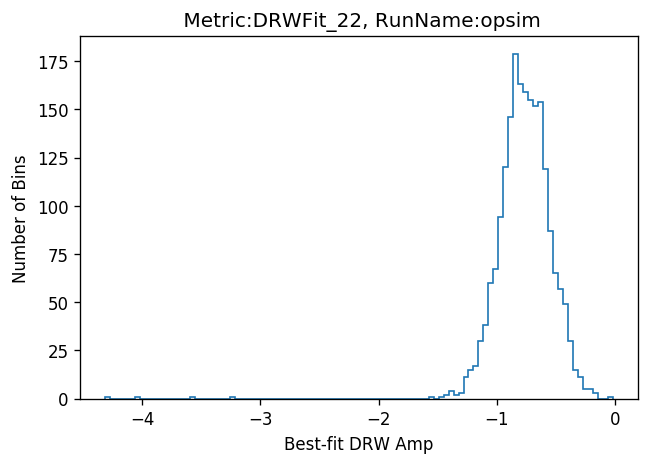

In [95]:
plotHist_MO(skymb, 0, 'Best-fit DRW Amp', dim=2, scale_func=np.log10)

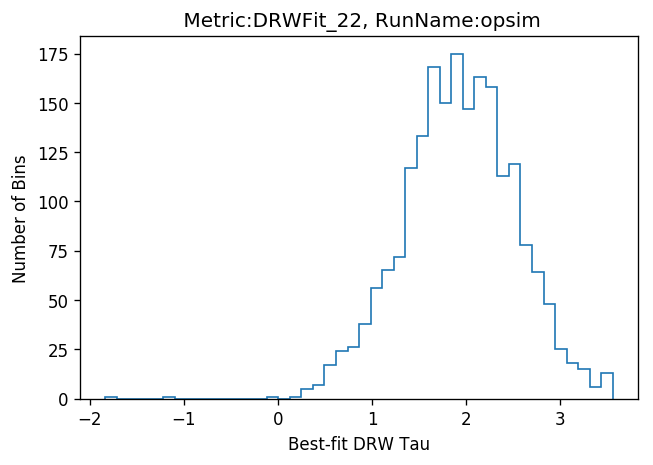

In [96]:
plotHist_MO(skymb, 1, 'Best-fit DRW Tau', dim=2, scale_func=np.log10)